# Chapter08

---

### 前準備

In [64]:
import numpy as np
import matplotlib.pyplot as plt

from common.np import *
from common.layers import Softmax
from common.optimizer import Adam
from common.time_layers import *
from common.trainer import Trainer
from common.util import eval_seq2seq
from dataset import sequence
from etc.seq2seq import Encoder, Seq2seq
from etc.peeky_seq2seq import PeekySeq2seq

## Attention

- 注意機構(Attention mechanism)
- seq2seqの根本的問題を解決する改良案
- seq2seqの問題点
  - Encoderの出力が固定長のベクトルであること
    - 情報が大きくても無理やり圧縮するため必要な情報が溢れる

---

### Encoderの改良案

- 今までは最後のLSTMの隠れ状態ベクトルを使用していた
  - 今回は各時刻のLSTMの隠れ状態ベクトルを使用する
    - これによって入力された単語列と同じ長さのベクトルを得れる
    - 各時刻の隠れ状態には直前に入力された単語の情報が多く含まれている
      - Encorderの出力$hs$は各単語に対応したベクトルの集合体となる

---

### Decoderの改良案

- Encoderの出力を改良したためこちらも改良する必要がある
- 翻訳先の単語と対応関係にある翻訳元の単語の情報(アライメント)を抜き出す
  - 即ち, 必要情報だけに注意を向け, その情報から時系列変換を行う → Attention  
- 選ぶために各単語の重要度を表す重み$a$とベクトル$hs$による重み付き和を求める


In [54]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1)#.repeat(T, axis=1)
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)

        return dhs, da

---

- 各単語の重要度を表す重み$a$があれば上記によってコンテキストベクトルを得れる
  - $a$はどう求めるか？
- DecoderのLSTMレイヤの隠れ状態ベクトル$h$と$hs$の各単語ベクトルの類似度を数値で求める → ベクトルの内積を用いる
  - 求めたスコア$s$を正規化するためにSoftmax関数を適用

In [55]:
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

---

- 上の2つのレイヤをAttentionレイヤとして1つにまとめる
- ここまでの流れ
  - Decoderのその時間のLSTMレイヤの出力$h$と$hs$を用いてAttention Weightレイヤで重み$a$を得る
  - $a$と$hs$によってWeight Sumレイヤで重み付き和を計算しAffineレイヤに向けて出力

In [56]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

---

- 時系列方向に広がる複数のAttentionレイヤをTime Attentionレイヤとしてまとめる

In [57]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None
        
    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []
        
        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)
        
        return out
    
    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)
        
        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:, t, :] = dh
        
        return dhs_enc, dhs_dec

---

## Attention付きseq2seqの実装

※前章のseq2seqを使用するが再実装が手間なのでフォルダから同クラスを呼び出すことにした

In [58]:
class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs
    
    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [59]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

In [60]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

---

## Attentionの評価

- 翻訳データセットの有名なもの: WMT
  - 英語とフランス語, または英語とドイツ語が対となったデータセット
  - 多くの研究でベンチマークとして利用されているが容量が20GB以上と大きく気軽に利用できない

- 今回は日付フォーマットを変更する問題に取り組む
  - 様々な形状の日付フォーマットを"YYYY-MM-DD"の形状にする

In [61]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('/date.txt')
char_to_id, id_to_char = sequence.get_vocab()

x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)
    
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

model.save_params()

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 13[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 26[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 39[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 51[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 64[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 77[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 90[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 103[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 115[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 128[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 141[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 153[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 166[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 178[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 191[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 204[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 216[s] | loss 1.00
Q 10/15/94                     
T 1994-10-1

| epoch 6 |  iter 101 / 351 | time 62[s] | loss 0.00
| epoch 6 |  iter 121 / 351 | time 75[s] | loss 0.00
| epoch 6 |  iter 141 / 351 | time 87[s] | loss 0.00
| epoch 6 |  iter 161 / 351 | time 100[s] | loss 0.00
| epoch 6 |  iter 181 / 351 | time 112[s] | loss 0.00
| epoch 6 |  iter 201 / 351 | time 125[s] | loss 0.00
| epoch 6 |  iter 221 / 351 | time 137[s] | loss 0.00
| epoch 6 |  iter 241 / 351 | time 150[s] | loss 0.00
| epoch 6 |  iter 261 / 351 | time 162[s] | loss 0.00
| epoch 6 |  iter 281 / 351 | time 174[s] | loss 0.00
| epoch 6 |  iter 301 / 351 | time 187[s] | loss 0.00
| epoch 6 |  iter 321 / 351 | time 199[s] | loss 0.00
| epoch 6 |  iter 341 / 351 | time 212[s] | loss 0.00
Q 10/15/94                     
T 1994-10-15
O 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
O 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
O 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
O 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
O 1970-0

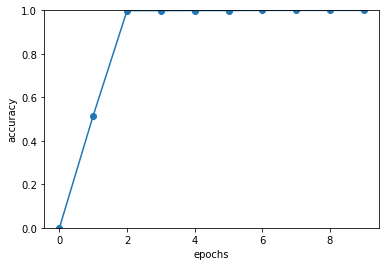

In [65]:
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()